Данный блокнот пересчитывает параметры протокола RFID и значения BER во
входные данные для имитационных и аналитических моделей,
которые рассчитывают время, необходимое для чтения RFID метки.
Порядок работы с блокнотом:
1) Задать параметры протокола RFID
2) Выбрать номер сценария и задать дополнительные настройки
3) Запустить вычисление входных параметров для моделей (массивов вероятностей и временных промежутков) на основе ранее заданных параметров
4) Запустить расчёт одной или нескольких имитационных моделей
5) Запустить расчёт одной или нескольких аналитических моделей
6) На основе полученных результатов построить графики

In [1]:
from itertools import product
import math # Для работы аналитической модели
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

# Подключение старые пакеты для моделирования протокола RFID
from pysim.models.monte_carlo.protocol import (TagFrame, ReaderFrame, TagEncoding,
    Sel, DR, Session, Bank, InventoryFlag as Flag,
    Query, QueryRep, Ack, ReqRn, Read,
    Rn16Reply, AckReply, ReqRnReply, ReadReply, max_t1, max_t2)

# Подключение имитационок для аналитики
from pysim.models.monte_carlo.cli import create_config, run_multiple_simulation

# Форматирование и работа с графиками
from utility.jupyter_helpers import setup_matplotlib, get_color, savefig, \
    set_axes_formatter

In [2]:
# Параметры модели
POINTS_NUMBER = 10 # Количество моделируемых точек (= имитационок)
# BER = 0.001 # Для рассчёта одной точки
BER = np.linspace(0, 0.01, num=POINTS_NUMBER) # Для рассчёта нескольких точек
CHUNKS_NUMBER = 1
WORDS_NUMBER = 8

# Параметры протокола RFID
DRS = [DR.DR_8]
M = [TagEncoding.FM0]
TARI_US = [6.25]
TRExt = (False,)

In [3]:
# Константы для запуска имитационной модели
MODEL_NAME = 'Monte-Carlo-simulation'
DEFAULT_PROBABILITY = ((1, 1, 1, 0.91),)
DEFAULT_PROCESSING_TIME = ((1, 1, 1, 1),)
DEFAULT_MAX_TRANSMISSIONS = 2000
DEFAULT_SCENARIO = 1
if CHUNKS_NUMBER > 1:
    DEFAULT_SCENARIO = 3
SCENARIOS_TUPLE = (1, 2, 3)

In [4]:
# Для 3-го сценария рассчёт размера 'чанков'
words_number_in_one_chunk = WORDS_NUMBER
last_chunk_len = 0
number_chunks_to_send = CHUNKS_NUMBER
if CHUNKS_NUMBER > 1:
    words_number_in_one_chunk = WORDS_NUMBER // CHUNKS_NUMBER
    last_chunk_len = WORDS_NUMBER // CHUNKS_NUMBER + WORDS_NUMBER % CHUNKS_NUMBER
        
print(f'Слов в одном чанке: {words_number_in_one_chunk}')
print(f'Слов в последнем чанке: {last_chunk_len}')

Слов в одном чанке: 8
Слов в последнем чанке: 0


In [5]:
def random_hex_string(bs: int) -> str:
    '''
    Функция для генерации случайного EPC и TID
    '''
    return "".join([f"{np.random.randint(0, 256):02X}" for _ in range(bs)])

In [6]:
# Параметры протокола RFID, которые не изменяются в рамках всего исследования
Q = 4             # по-умолчанию, будем исходить из этого значения параметра Q
RTCAL_MUL = 2.75  # во сколько раз RTcal больше Tari
TRCAL_MUL = 1.95  # во сколько раз TRcal больше RTcal
EPC_SIZE = 12     # длина EPCID в байтах
TID_SIZE = 8      # длина TID в байтах

EPC = random_hex_string(EPC_SIZE)
TID = random_hex_string(TID_SIZE)

delta = 1e-5 # с. Константа для рассчёта времени

print("Будут использованы следующие константы:")
print(f"- EPC: {EPC} ({EPC_SIZE} bytes)")
print(f"- TID: {TID} ({TID_SIZE} bytes)")

Будут использованы следующие константы:
- EPC: 10E3E4043B018252CB207EC9 (12 bytes)
- TID: 8BE4D06BC17EEFC8 (8 bytes)


In [7]:
def build_messages_df() -> pd.DataFrame:
    """
    Построить DataFrame для всевозможных настроек канала и рассчитанными 
    длительностями команд и ответов.
    
    В датафрейме используются следующие единицы измерений:
    
    - для длительностей: микросекунды (мкс)
    - для частот: килогерцы (КГц)
    - для скоростей: килобиты в секунду (кбит/с)
    
    Returns:
        df (DataFrame)
    """
    params = []
    for tari_us, m, dr, trext in product(TARI_US, M, DRS, TRExt):
        tari = tari_us * 1e-6
        rtcal = RTCAL_MUL * tari
        trcal = TRCAL_MUL * rtcal
        blf = dr.ratio / trcal
        bitrate = blf / m.value
        
        # Строим команды
        # --------------
        preamble = ReaderFrame.Preamble(tari, rtcal, trcal)
        sync = ReaderFrame.Sync(tari, rtcal)
        
        query = Query(dr=dr, m=m, trext=trext, sel=Sel.SL_ALL, 
                           session=Session.S0, target=Flag.A, 
                           q=Q, crc5=0x15)
        query_rep = QueryRep(session=Session.S0)
        ack = Ack(0x5555)
        req_rn = ReqRn(0x5555, 0x5555)
        read = Read(Bank.TID, 0, 4, rn=0x5555, crc16=0x5555)
        
        # Строим ответы
        # -------------
        rn16 = Rn16Reply(0x5555)
        epc_pc = AckReply(EPC)
        handle = ReqRnReply(0)
        data = []
        # Для 3го сценария создаём несколько ответов для каждого 'чанка'
        if CHUNKS_NUMBER > 1:
            for i in range(CHUNKS_NUMBER-1):
                data.append(ReadReply([0xABAB] * words_number_in_one_chunk, 0, 0))
            data.append(ReadReply([0xABAB] * last_chunk_len, 0, 0))
        else:
            data = [ReadReply([0xABAB] * WORDS_NUMBER, 0, 0)]
        data_durations = []
        data_lens = []
        for data_answer in data:
            data_durations.append(TagFrame(m, trext, blf, data_answer).duration)
            data_lens.append(TagFrame(m, trext, blf, data_answer).bitlen)

        params.append({
            'DR': dr,
            'M': m,
            'Tari': tari_us,     
            'TRext': trext,
            'RTcal': rtcal,
            'TRcal': trcal,
            'BLF': blf,
            'Query': ReaderFrame(preamble, query).duration,
            'QueryRep': ReaderFrame(sync, query_rep).duration,
            'Ack': ReaderFrame(sync, ack).duration,
            'Req_RN': ReaderFrame(sync, req_rn).duration,
            'Read': ReaderFrame(sync, read).duration,
            'Query_len': 22,
            'RN16': TagFrame(m, trext, blf, rn16).duration,
            'EPC+PC+CRC': TagFrame(m, trext, blf, epc_pc).duration,
            'Handle': TagFrame(m, trext, blf, handle).duration,
            'Data': data_durations,
            'RN16_len': TagFrame(m, trext, blf, rn16).bitlen,
            'EPC+PC+CRC_len': TagFrame(m, trext, blf, epc_pc).bitlen,
            'Handle_len': TagFrame(m, trext, blf, handle).bitlen,
            'Data_len': data_lens,
        })
    return params

params = build_messages_df()
DF = pd.DataFrame(params)

Вероятность успешного перехода из одного состояния в другое определяется
исключительно ответами метки (так как во всём проекте сделано допущение, что
если метка оказалась в зоне чтения, то она гарантировано включается, корректно
получает команду считывателя и принимает участие в текущем раунде). Вероятность
перехода в следующее состояние равна вероятности успешного получения считывателем
ответа метки.
Вероятность определяется выражением:
$$ P_{msg} = (1 - BER)^{|msg|} $$
где msg - передаваемое сообщение, BER - вероятность битовой ошибки, |msg| - длина сообщения в битах

In [8]:
reply_lens = [
    params[0]['RN16_len'],
    params[0]['EPC+PC+CRC_len'],
    params[0]['Handle_len'],
]
for i in range(CHUNKS_NUMBER):
    reply_lens.append(params[0]['Data_len'][i])

probabilities = []
for i in range(len(reply_lens)):
    probabilities.append((1 - BER) ** reply_lens[i])
print('Рассчитанные вероятности:')
pprint(probabilities)

# Группировка вероятностей по массивам:
# [
#   [Массив вероятностей 1], ..., [Массив вероятностей n]
# ]
probs = []
sub_probabilities = []
for i in range(POINTS_NUMBER):
    for state_number in range(len(reply_lens)):
        sub_probabilities.append(probabilities[state_number][i])
    probs.append(sub_probabilities)
    sub_probabilities = []
print('Сгрупированные вероятности:')
pprint(probs)

Рассчитанные вероятности:
[array([1.        , 0.97475437, 0.95011905, 0.92607993, 0.90262323,
       0.87973545, 0.85740343, 0.83561425, 0.81435531, 0.79361428]),
 array([1.        , 0.8606362 , 0.74057096, 0.63714905, 0.5480782 ,
       0.47137983, 0.40534635, 0.34850433, 0.29958259, 0.25748461]),
 array([1.        , 0.95756907, 0.91689428, 0.87790477, 0.8405325 ,
       0.80471206, 0.77038065, 0.73747793, 0.70594595, 0.67572905]),
 array([1.        , 0.82963416, 0.68814978, 0.570675  , 0.47315566,
       0.39221875, 0.32505853, 0.26934164, 0.22312794, 0.18480456])]
Сгрупированные вероятности:
[[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)],
 [np.float64(0.9747543742077994),
  np.float64(0.8606362005788438),
  np.float64(0.9575690695248866),
  np.float64(0.829634159329628)],
 [np.float64(0.9501190508939553),
  np.float64(0.7405709561020657),
  np.float64(0.9168942767866947),
  np.float64(0.6881497783069531)],
 [np.float64(0.9260799313517637),
  np.float64(0.63714

Время перехода из одного состояния в другое вычисляется по формулам:
$$T_{Arbitrate} = T_{Query} + T_1 + T_{RN16} + T_2 + 2\delta$$ 
$$T_{Reply} = T_{Ack} + T_1 + T_{EPC} + T_2 + 2\delta$$
$$T_{Acknowledged} = T_{Req_RN} + T_1 + T_{Handle} + T_2 + 2\delta$$
$$T_{Secured} = T_{Read} + T_1 + T_{Data} + T_2 + 2\delta$$
$$T_{Secured.Ri} = T_{Read} + T_1 + T_{Chunk.i} + T_2 + 2\delta$$
$$T_{Secured.LC} = T_{Read} + T_1 + T_{Last.Chunk} + T_2 + 2\delta$$
где $T_{msg.name}$ - длительность команды считывателя или ответа метки, 
$T_{Secured.Ri}$ - длительность для i-го 'чанка', 
$T_{Secured.ДС}$ - длительность последнего 'чанка', 
$T_1$ и $T_2$ - параметры, определяемые протоколом RFID (в блокноте рассчитываются с помощью функций), 
$\delta$ - время распространения сигнала (в блокноте определяется как взятая наобум константа)

In [9]:
T1 = max_t1(params[0]['RTcal'], params[0]['BLF'])
T2 = max_t2(params[0]['BLF'])
T1_2 = T1 + T2

In [10]:
times = []
T_arbitrate = T1_2 + params[0]['Query'] + params[0]['RN16'] + 2 * delta
times.append(T_arbitrate)
T_reply = T1_2 + params[0]['Ack'] + params[0]['EPC+PC+CRC'] + 2 * delta
times.append(T_reply)
T_acknowledged = T1_2 + params[0]['Req_RN'] + params[0]['Handle'] + 2 * delta
times.append(T_acknowledged)

for i in range(CHUNKS_NUMBER):
    t_chunk = T1_2 + params[0]['Read'] + params[0]['Data'][i] + 2 * delta
    times.append(t_chunk)
times

[0.00047862109374999993,
 0.0009080742187499999,
 0.0006902617187499999,
 0.0013525761718749998]

In [11]:
# Ячейка группирует входные массивы парами:
# [
#   [[Массив вероятностей 1],[Массив времён 1]], ...
#   [[Массив вероятностей n],[Массив времён n]],
# ]
# initial_data_pairs = []
# sub_probabilities = []
# sub_times = []
# for i in range(POINTS_NUMBER):
#     for state_number in range(len(reply_lens)):
#         sub_probabilities.append(probabilities[state_number][i])
#     initial_data_pairs.append((sub_probabilities, times))
#     sub_probabilities = []
# initial_data_pairs



In [12]:
# Группировка вероятностей по массивам:
# [
#   [Массив вероятностей 1], ..., [Массив вероятностей n]
# ]
probs = []
sub_probabilities = []
for i in range(POINTS_NUMBER):
    for state_number in range(len(reply_lens)):
        sub_probabilities.append(probabilities[state_number][i])
    probs.append(sub_probabilities)
    sub_probabilities = []
print('Сгрупированные вероятности:')
pprint(probs)

Сгрупированные вероятности:
[[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)],
 [np.float64(0.9747543742077994),
  np.float64(0.8606362005788438),
  np.float64(0.9575690695248866),
  np.float64(0.829634159329628)],
 [np.float64(0.9501190508939553),
  np.float64(0.7405709561020657),
  np.float64(0.9168942767866947),
  np.float64(0.6881497783069531)],
 [np.float64(0.9260799313517637),
  np.float64(0.6371490452183012),
  np.float64(0.8779047737653359),
  np.float64(0.5706749975147037)],
 [np.float64(0.9026232274042398),
  np.float64(0.5480782023669489),
  np.float64(0.8405324964658604),
  np.float64(0.4731556576454626)],
 [np.float64(0.8797354548993922),
  np.float64(0.47137982771885373),
  np.float64(0.8047120584404158),
  np.float64(0.3922187463966538)],
 [np.float64(0.8574034273346864),
  np.float64(0.4053463466742837),
  np.float64(0.7703806482705066),
  np.float64(0.32505853364895837)],
 [np.float64(0.8356142496083467),
  np.float64(0.3485043278138243),
  np.float

In [13]:
# Копирование массивов времени по количеству
# массивов вероятности
t = []
for _ in range(len(probs)):
    t.append(times)
print('Копированные массивы времени: ')
pprint(t)

Копированные массивы времени: 
[[0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,
  0.0006902617187499999,
  0.0013525761718749998],
 [0.00047862109374999993,
  0.0009080742187499999,


In [14]:
# Подготовка словарей для запуска имитационок
# Словарь для запуска одной имитационки:
def create_dicts(probabilities, times, scenario):
    initial_dict = {
        'probability': probabilities,
        'processing_time': times,
        'max_transmisions': DEFAULT_MAX_TRANSMISSIONS,
        'chunks_number': CHUNKS_NUMBER,
        'scenario': scenario
    }
    # Словарь для запуска нескольких имитационок параллельно
    multiple_initial_dict = {
        'probability': probs,
        'processing_time': t,
        'max_transmisions': DEFAULT_MAX_TRANSMISSIONS,
        'chunks_number': CHUNKS_NUMBER,
        'scenario': DEFAULT_SCENARIO
    }
    return multiple_initial_dict

multiple_initial_dict = create_dicts(probabilities, times, DEFAULT_SCENARIO)

In [15]:
def run_set_simulations(start_dict):
    return run_multiple_simulation(start_dict)

results = run_set_simulations(multiple_initial_dict)

Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена


In [16]:
# Вывод на печать полученных результатов
res = []
for i in results:
    res.append(i.sim_time/DEFAULT_MAX_TRANSMISSIONS*1_000)
print(f'Результаты симуляции: {res}')
print(f'Значения BER: {BER}')

Результаты симуляции: [3.4295332031252768, 4.27643470507846, 5.428967398437663, 7.091938134765519, 9.013015498047716, 12.263912378911952, 16.582846869152615, 23.588281068357535, 32.656721806616524, 44.711694857367064]
Значения BER: [0.         0.00111111 0.00222222 0.00333333 0.00444444 0.00555556
 0.00666667 0.00777778 0.00888889 0.01      ]


Следующие ячейки описывают аналитическую модель.
Данные на входе и выходе аналитических и имитационных моделей идентичны.
Отличия могут быть быть только в формате.

In [17]:
# phases is array of tuples (p, t), where p is transmission prob, t is timeout time
def calculate_first_case(phases):
    res = 0;
    times = [phase[1] for phase in phases]
    probs = [phase[0] for phase in phases]
    
    for n1 in range(40):
        for n2 in range(40):
            for n3 in range(40):
                for n4 in range(40):
                    t = times[0] + times[1] + times[2] + times[3] + (n1 + n2+ n3 + n4) * times[0] + (n2 + n3 + n4) * times[1] + (n3 + n4) * times[2] + n4 * times[3]
                    p = ((1 - probs[0]) ** n1) * (probs[0] ** (n2 + n3 + n4 + 1)) * ((1 - probs[1]) ** n2) * (probs[1] ** (n3 + n4 + 1)) * ((1 - probs[2]) ** n3) * (probs[2] ** (n4 + 1)) * ((1 - probs[3]) ** n4) * probs[3]
                    fact = math.factorial(n1 + n2 + n3 + n4) / (math.factorial(n1) * math.factorial(n2) * math.factorial(n3) * math.factorial(n4))
                    res += t * p * fact

    return res
                        

In [18]:
# phases is array of tuples (p, t), where p is transmission prob, t is timeout time
def calculate_second_case(phases):
    res = 0

    for phase in phases:
        for n in range(1000):
            res += (n + 1) * phase[1] * phase[0] * ((1 - phase[0]) ** n)

    return res

In [19]:
def calculate_third_case(phases, chunk_phase, chunk_count):
    return calculate_second_case(phases) + chunk_count * calculate_second_case([chunk_phase])

In [20]:
# Коневертация данных в формат, который требуют аналитические модели
all_phases = []
sub_phase = []
for cases in range(len(probs)):
    for state_number in range(len(probs[0])):
        sub_phase.append((probs[cases][state_number], t[cases][state_number]))
    all_phases.append(sub_phase)
    sub_phase = []
# all_phases

In [21]:
def run_analitica(script_number: int):
    analit_res = []
    if script_number == 1:
        for i in range(len(all_phases)):
            analit_res.append(calculate_first_case(all_phases[i])*1_000)
    elif script_number == 2:
        for i in range(len(all_phases)):
            analit_res.append(calculate_second_case(all_phases[i])*1_000)
    elif script_number == 3:
        for i in range(3):
            analit_res.append(calculate_third_case(all_phases[i], all_phases[-1], CHUNKS_NUMBER)*1_000)
    return analit_res

analit_res = run_analitica(DEFAULT_SCENARIO)

Text(0, 0.5, 'Длительность ответа, мс')

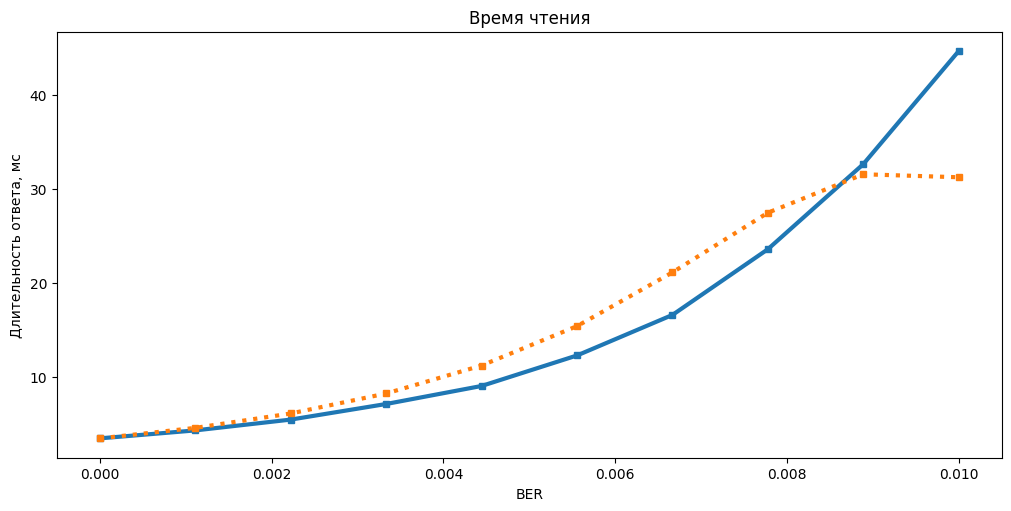

In [22]:
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(
    BER, res,
    linewidth=3, linestyle='-',
    marker='s',
    markersize=4,
)
ax.plot(
    BER, analit_res,
    linewidth=3, linestyle='dotted',
    marker='s',
    markersize=4,
)
ax.set_title('Время чтения')
ax.set_xlabel('BER') 
ax.set_ylabel('Длительность ответа, мс')